# Initial Setup 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from bdi_predict.ml_logic.sequence_gen import WindowGenerator
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
df = pd.read_csv("../raw_data/data/BDI/log_diff_BDI_daily.csv")
df.head(2)

,Unnamed: 0,Date,Price,abs_price,log_price,log_diff
0,0,1995-01-03,1964.0,NaN,3.293141,NaN
1,1,1995-01-04,1961.0,-3.0,3.292478,-0.000664


In [43]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df = df[df.index != "1995-01-03"]
df.drop(columns="Unnamed: 0", inplace=True)
df.head(2)

,Price,abs_price,log_price,log_diff
Date,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664
1995-01-05,1967.0,6.0,3.293804,0.001327


<AxesSubplot: xlabel='Date'>

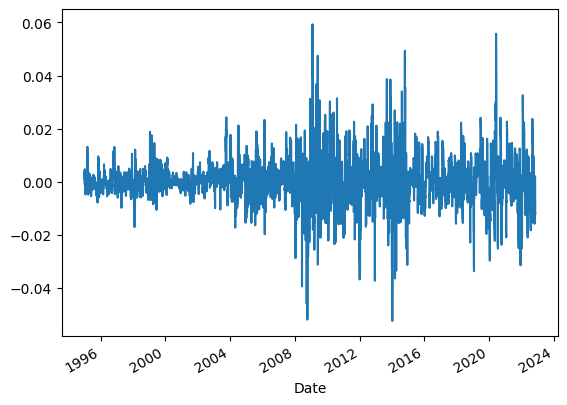

In [45]:
df["log_diff"].plot()

<AxesSubplot: xlabel='Date'>

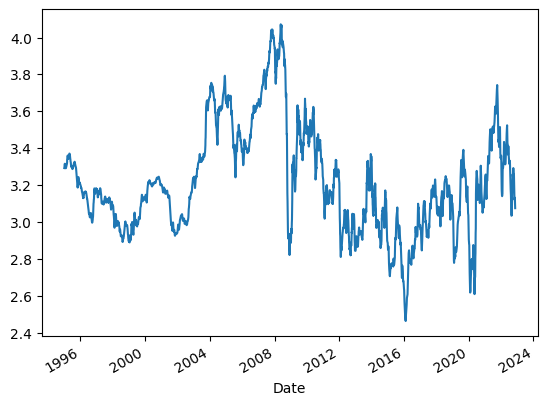

In [46]:
df["log_price"].plot()

<AxesSubplot: xlabel='Date'>

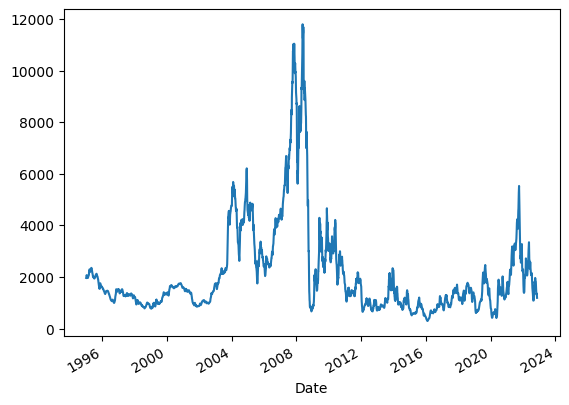

In [49]:
df["Price"].plot()

REMINDER: New target is: $$log(𝑦𝑡)−log(𝑦𝑡−1)=log(𝑦𝑡/𝑦𝑡−1)$$

# Using our bespoke window/sequence generator to generate sequences:

1. Generate sequences that predict the log difference a day ahead with input length of 10 days (two weeks) 
2. generate sequences that predict the log differences a day ahead with input length of 20 days (a month)

In [50]:
input_length = len(df)

In [51]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [52]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [53]:
X_train = df_train[["Price"]]
y_train = df_train["log_diff"]

X_test  = df_test[["Price"]]
y_test = df_test["log_diff"]

In [54]:
#Feature Scaling

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.fit_transform(X_test)



In [55]:
X_train_scaled[:2]

array([[0.14519214],
       [0.14571379]])

In [56]:
y_train[:2]

Date
1995-01-04   -0.000664
1995-01-05    0.001327
Name: log_diff, dtype: float64

In [17]:
# scaler_y = MinMaxScaler()

# y_train_scaled = scaler_y.fit_transform(y_train)
# y_test_scaled = scaler_y.fit_transform(y_test)

In [18]:
generator = TimeseriesGenerator(X_train_scaled, y_train, length=10, batch_size=4, sampling_rate=1, stride=1)

In [19]:
generator_val = TimeseriesGenerator(X_test_scaled, y_test, length=10, batch_size=4, sampling_rate=1, stride=1)

In [20]:
len(generator)

1411

In [21]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    #listy = [float(X[0][i]) for i in range(len(X[0]))]
    #print(listy)
    break

(4, 10, 1) (4,)
[[0.14519214]
 [0.14571379]
 [0.14710485]
 [0.14806121]
 [0.14988698]
 [0.15023474]
 [0.15188663]
 [0.15379934]
 [0.15440793]
 [0.15475569]] 0.0


# Using TimseriesGenerator to create sequences:

# The Model

In [22]:
# Learning Rate Scheduler: 

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [23]:
#Optimizers

rmsprop = RMSprop(learning_rate=lr_schedule) #or 0.001 for inital test
adam = Adam(learning_rate=lr_schedule)

In [24]:
#Early Stopping Criterion:

es = EarlyStopping(monitor="val_mae", patience=100, restore_best_weights=True)

In [25]:
#Initializing and compiling model:

def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(60, activation="tanh", input_shape=(10,1), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training and Testing

In [26]:
X_train_scaled[:2]

array([[0.14519214],
       [0.14571379]])

In [27]:
y_train[:5]

Date
1995-01-04   -0.000664
1995-01-05    0.001327
1995-01-06    0.003518
1995-01-09    0.002402
1995-01-10    0.004550
Name: log_diff, dtype: float64

In [35]:
#Instantiating model

model = init_model()

#TRAINING THE MODEL:

history = model.fit(
    generator, epochs=1000, validation_data=generator_val, shuffle=False, callbacks=es
)

Epoch 1/1000
1411/1411 [==============================] - 5s 3ms/step - loss: 5.1822e-05 - mae: 0.0048 - val_loss: 0.0052 - val_mae: 0.0587
Epoch 2/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 5.0053e-05 - mae: 0.0046 - val_loss: 0.0067 - val_mae: 0.0665
Epoch 3/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 4.9261e-05 - mae: 0.0046 - val_loss: 0.0076 - val_mae: 0.0700
Epoch 4/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 5.1051e-05 - mae: 0.0046 - val_loss: 0.0070 - val_mae: 0.0671
Epoch 5/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 5.1741e-05 - mae: 0.0046 - val_loss: 0.0075 - val_mae: 0.0693
Epoch 6/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 4.9415e-05 - mae: 0.0045 - val_loss: 0.0043 - val_mae: 0.0530
Epoch 7/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 4.9632e-05 - mae: 0.0045 - val_loss: 0.0088 - val_mae: 0.0752
Epoch 8/1000
1411/14

1411/1411 [==============================] - 3s 2ms/step - loss: 4.0761e-05 - mae: 0.0040 - val_loss: 0.0018 - val_mae: 0.0385
Epoch 60/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 4.0357e-05 - mae: 0.0040 - val_loss: 0.0018 - val_mae: 0.0384
Epoch 61/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 3.9547e-05 - mae: 0.0040 - val_loss: 0.0018 - val_mae: 0.0385
Epoch 62/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 3.9136e-05 - mae: 0.0040 - val_loss: 0.0019 - val_mae: 0.0402
Epoch 63/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 3.8521e-05 - mae: 0.0039 - val_loss: 0.0020 - val_mae: 0.0412
Epoch 64/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 3.7875e-05 - mae: 0.0039 - val_loss: 0.0021 - val_mae: 0.0417
Epoch 65/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 3.7354e-05 - mae: 0.0039 - val_loss: 0.0022 - val_mae: 0.0426
Epoch 66/1000
1411/1411 [==

1411/1411 [==============================] - 3s 2ms/step - loss: 2.4633e-05 - mae: 0.0031 - val_loss: 9.9409e-04 - val_mae: 0.0292
Epoch 118/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4598e-05 - mae: 0.0031 - val_loss: 9.6242e-04 - val_mae: 0.0287
Epoch 119/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4568e-05 - mae: 0.0031 - val_loss: 9.5715e-04 - val_mae: 0.0286
Epoch 120/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4514e-05 - mae: 0.0030 - val_loss: 9.7578e-04 - val_mae: 0.0289
Epoch 121/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4517e-05 - mae: 0.0030 - val_loss: 9.2070e-04 - val_mae: 0.0281
Epoch 122/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4202e-05 - mae: 0.0030 - val_loss: 9.3962e-04 - val_mae: 0.0283
Epoch 123/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.4153e-05 - mae: 0.0030 - val_loss: 9.3116e-04 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 2.1353e-05 - mae: 0.0028 - val_loss: 3.6366e-04 - val_mae: 0.0176
Epoch 174/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.1314e-05 - mae: 0.0028 - val_loss: 3.5237e-04 - val_mae: 0.0173
Epoch 175/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.1255e-05 - mae: 0.0028 - val_loss: 3.4638e-04 - val_mae: 0.0171
Epoch 176/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.1235e-05 - mae: 0.0028 - val_loss: 3.3675e-04 - val_mae: 0.0169
Epoch 177/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.1197e-05 - mae: 0.0028 - val_loss: 3.3248e-04 - val_mae: 0.0167
Epoch 178/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.1174e-05 - mae: 0.0028 - val_loss: 3.2530e-04 - val_mae: 0.0165
Epoch 179/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.1155e-05 - mae: 0.0028 - val_loss: 3.2359e-04 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 2.0357e-05 - mae: 0.0028 - val_loss: 1.5570e-04 - val_mae: 0.0111
Epoch 230/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0337e-05 - mae: 0.0028 - val_loss: 1.5350e-04 - val_mae: 0.0110
Epoch 231/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0341e-05 - mae: 0.0028 - val_loss: 1.5054e-04 - val_mae: 0.0109
Epoch 232/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0304e-05 - mae: 0.0027 - val_loss: 1.4863e-04 - val_mae: 0.0108
Epoch 233/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0296e-05 - mae: 0.0027 - val_loss: 1.4584e-04 - val_mae: 0.0107
Epoch 234/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0296e-05 - mae: 0.0027 - val_loss: 1.4406e-04 - val_mae: 0.0106
Epoch 235/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 2.0274e-05 - mae: 0.0027 - val_loss: 1.4280e-04 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.9552e-05 - mae: 0.0027 - val_loss: 7.2079e-05 - val_mae: 0.0070
Epoch 286/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9539e-05 - mae: 0.0027 - val_loss: 7.1373e-05 - val_mae: 0.0069
Epoch 287/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9530e-05 - mae: 0.0027 - val_loss: 7.0173e-05 - val_mae: 0.0068
Epoch 288/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9520e-05 - mae: 0.0027 - val_loss: 6.9511e-05 - val_mae: 0.0068
Epoch 289/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9511e-05 - mae: 0.0027 - val_loss: 6.9102e-05 - val_mae: 0.0068
Epoch 290/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9506e-05 - mae: 0.0027 - val_loss: 6.8339e-05 - val_mae: 0.0067
Epoch 291/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9496e-05 - mae: 0.0027 - val_loss: 6.7464e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.9185e-05 - mae: 0.0027 - val_loss: 4.5558e-05 - val_mae: 0.0048
Epoch 342/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9182e-05 - mae: 0.0027 - val_loss: 4.5391e-05 - val_mae: 0.0048
Epoch 343/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9178e-05 - mae: 0.0027 - val_loss: 4.5067e-05 - val_mae: 0.0047
Epoch 344/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9174e-05 - mae: 0.0027 - val_loss: 4.4900e-05 - val_mae: 0.0047
Epoch 345/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9170e-05 - mae: 0.0027 - val_loss: 4.4593e-05 - val_mae: 0.0047
Epoch 346/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9166e-05 - mae: 0.0026 - val_loss: 4.4320e-05 - val_mae: 0.0047
Epoch 347/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9163e-05 - mae: 0.0026 - val_loss: 4.3968e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.9025e-05 - mae: 0.0026 - val_loss: 3.7118e-05 - val_mae: 0.0038
Epoch 398/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9024e-05 - mae: 0.0026 - val_loss: 3.7035e-05 - val_mae: 0.0038
Epoch 399/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9023e-05 - mae: 0.0026 - val_loss: 3.6935e-05 - val_mae: 0.0037
Epoch 400/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9021e-05 - mae: 0.0026 - val_loss: 3.6857e-05 - val_mae: 0.0037
Epoch 401/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9021e-05 - mae: 0.0026 - val_loss: 3.6765e-05 - val_mae: 0.0037
Epoch 402/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9019e-05 - mae: 0.0026 - val_loss: 3.6672e-05 - val_mae: 0.0037
Epoch 403/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.9018e-05 - mae: 0.0026 - val_loss: 3.6575e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8979e-05 - mae: 0.0026 - val_loss: 3.3990e-05 - val_mae: 0.0033
Epoch 454/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8979e-05 - mae: 0.0026 - val_loss: 3.3953e-05 - val_mae: 0.0033
Epoch 455/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8978e-05 - mae: 0.0026 - val_loss: 3.3933e-05 - val_mae: 0.0033
Epoch 456/1000
1411/1411 [==============================] - 6s 4ms/step - loss: 1.8978e-05 - mae: 0.0026 - val_loss: 3.3901e-05 - val_mae: 0.0033
Epoch 457/1000
1411/1411 [==============================] - 4s 3ms/step - loss: 1.8978e-05 - mae: 0.0026 - val_loss: 3.3865e-05 - val_mae: 0.0033
Epoch 458/1000
1411/1411 [==============================] - 4s 2ms/step - loss: 1.8978e-05 - mae: 0.0026 - val_loss: 3.3839e-05 - val_mae: 0.0033
Epoch 459/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8977e-05 - mae: 0.0026 - val_loss: 3.3817e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8966e-05 - mae: 0.0026 - val_loss: 3.2919e-05 - val_mae: 0.0031
Epoch 510/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8966e-05 - mae: 0.0026 - val_loss: 3.2908e-05 - val_mae: 0.0031
Epoch 511/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8965e-05 - mae: 0.0026 - val_loss: 3.2898e-05 - val_mae: 0.0031
Epoch 512/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8965e-05 - mae: 0.0026 - val_loss: 3.2890e-05 - val_mae: 0.0031
Epoch 513/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8965e-05 - mae: 0.0026 - val_loss: 3.2881e-05 - val_mae: 0.0031
Epoch 514/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8965e-05 - mae: 0.0026 - val_loss: 3.2871e-05 - val_mae: 0.0031
Epoch 515/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8964e-05 - mae: 0.0026 - val_loss: 3.2865e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8954e-05 - mae: 0.0026 - val_loss: 3.2627e-05 - val_mae: 0.0031
Epoch 566/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8953e-05 - mae: 0.0026 - val_loss: 3.2625e-05 - val_mae: 0.0031
Epoch 567/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8953e-05 - mae: 0.0026 - val_loss: 3.2623e-05 - val_mae: 0.0031
Epoch 568/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8953e-05 - mae: 0.0026 - val_loss: 3.2621e-05 - val_mae: 0.0031
Epoch 569/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8953e-05 - mae: 0.0026 - val_loss: 3.2619e-05 - val_mae: 0.0031
Epoch 570/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8952e-05 - mae: 0.0026 - val_loss: 3.2618e-05 - val_mae: 0.0031
Epoch 571/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8952e-05 - mae: 0.0026 - val_loss: 3.2614e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8945e-05 - mae: 0.0026 - val_loss: 3.2566e-05 - val_mae: 0.0031
Epoch 622/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8944e-05 - mae: 0.0026 - val_loss: 3.2565e-05 - val_mae: 0.0031
Epoch 623/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8944e-05 - mae: 0.0026 - val_loss: 3.2565e-05 - val_mae: 0.0031
Epoch 624/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8944e-05 - mae: 0.0026 - val_loss: 3.2564e-05 - val_mae: 0.0031
Epoch 625/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8944e-05 - mae: 0.0026 - val_loss: 3.2563e-05 - val_mae: 0.0031
Epoch 626/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8944e-05 - mae: 0.0026 - val_loss: 3.2563e-05 - val_mae: 0.0031
Epoch 627/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8944e-05 - mae: 0.0026 - val_loss: 3.2562e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2548e-05 - val_mae: 0.0031
Epoch 678/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2548e-05 - val_mae: 0.0031
Epoch 679/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 680/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 681/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 682/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 683/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8940e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8938e-05 - mae: 0.0026 - val_loss: 3.2546e-05 - val_mae: 0.0031
Epoch 734/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8938e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 735/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8938e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 736/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8938e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 737/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8938e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 738/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8938e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 0.0031
Epoch 739/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8938e-05 - mae: 0.0026 - val_loss: 3.2547e-05 - val_mae: 

1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2551e-05 - val_mae: 0.0031
Epoch 790/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2551e-05 - val_mae: 0.0031
Epoch 791/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2552e-05 - val_mae: 0.0031
Epoch 792/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2552e-05 - val_mae: 0.0031
Epoch 793/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2553e-05 - val_mae: 0.0031
Epoch 794/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2553e-05 - val_mae: 0.0031
Epoch 795/1000
1411/1411 [==============================] - 3s 2ms/step - loss: 1.8937e-05 - mae: 0.0026 - val_loss: 3.2554e-05 - val_mae: 

In [36]:
#Model layers & params overview:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60)                14880     
                                                                 
 dense_4 (Dense)             (None, 150)               9150      
                                                                 
 dense_5 (Dense)             (None, 1)                 151       
                                                                 
Total params: 24,181
Trainable params: 24,181
Non-trainable params: 0
_________________________________________________________________


array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

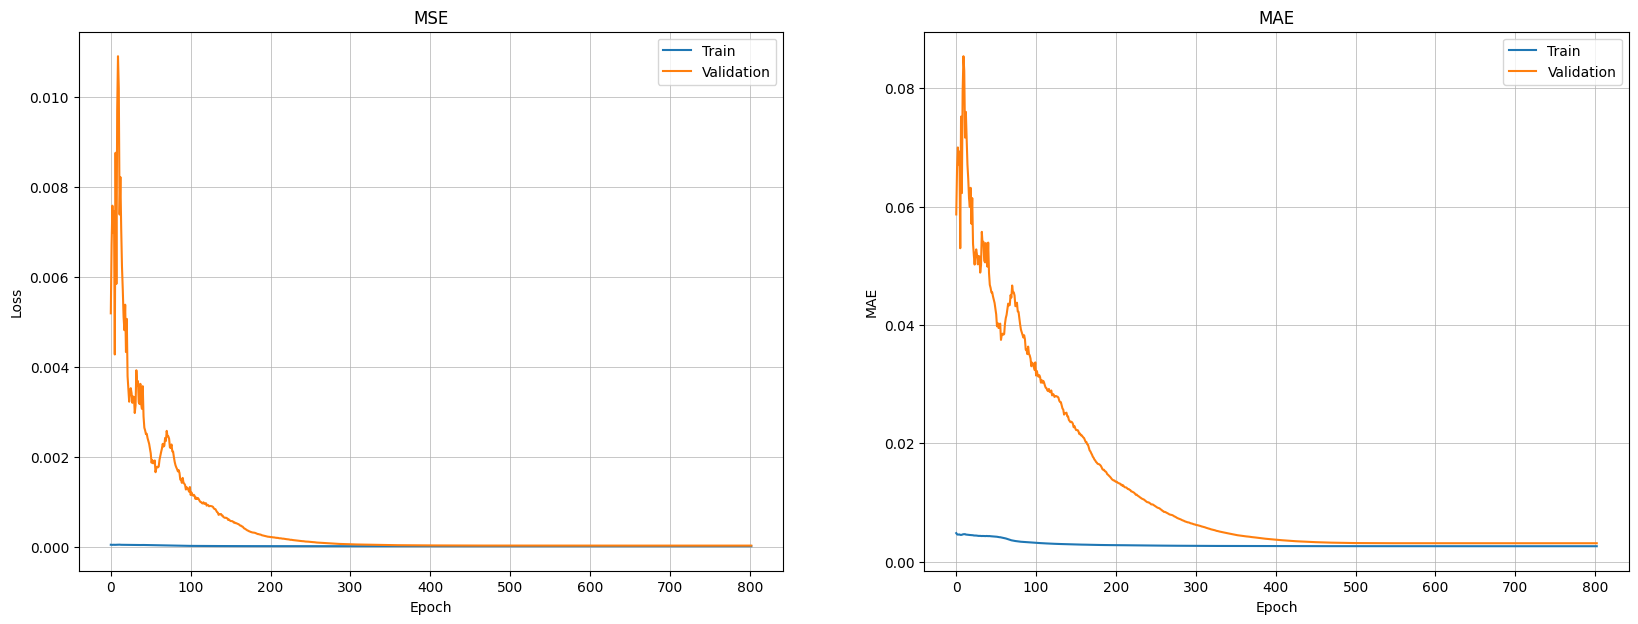

In [37]:
# Learning Curves:
plot_history(history)

In [39]:
model.save("../raw_data/data/BDI/univariate_log_model_2")

2022-11-28 10:38:43.070481: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../raw_data/data/BDI/univariate_log_model_2/assets


INFO:tensorflow:Assets written to: ../raw_data/data/BDI/univariate_log_model_2/assets


# Reinterpreting the y_pred to an actual absolute BDI value

In [58]:
df.head(11)

,Price,abs_price,log_price,log_diff
Date,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664
1995-01-05,1967.0,6.0,3.293804,0.001327
1995-01-06,1983.0,16.0,3.297323,0.003518
1995-01-09,1994.0,11.0,3.299725,0.002402
1995-01-10,2015.0,21.0,3.304275,0.004550
1995-01-11,2019.0,4.0,3.305136,0.000861
1995-01-12,2038.0,19.0,3.309204,0.004068
1995-01-13,2060.0,22.0,3.313867,0.004663
1995-01-16,2067.0,7.0,3.315340,0.001473


In [135]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    listx = [float(X[0][i]) for i in range(len(X[0]))]
    print(listx)
    

(4, 10, 1) (4,)
[[0.14519214]
 [0.14571379]
 [0.14710485]
 [0.14806121]
 [0.14988698]
 [0.15023474]
 [0.15188663]
 [0.15379934]
 [0.15440793]
 [0.15475569]] 0.0
[0.1451921404973048, 0.14571378890627718, 0.14710485133020343, 0.14806120674665274, 0.149886976178056, 0.15023474178403756, 0.15188662841245001, 0.15379933924534864, 0.15440792905581638, 0.15475569466179795]
(4, 10, 1) (4,)
[[0.14988698]
 [0.15023474]
 [0.15188663]
 [0.15379934]
 [0.15440793]
 [0.15475569]
 [0.15475569]
 [0.15466875]
 [0.1537124 ]
 [0.15240828]] -0.25571878507935003
[0.149886976178056, 0.15023474178403756, 0.15188662841245001, 0.15379933924534864, 0.15440792905581638, 0.15475569466179795, 0.15475569466179795, 0.15466875326030255, 0.15371239784385324, 0.15240827682142236]
(4, 10, 1) (4,)
[[0.15440793]
 [0.15475569]
 [0.15475569]
 [0.15466875]
 [0.1537124 ]
 [0.15240828]
 [0.15136498]
 [0.1501478 ]
 [0.14823509]
 [0.14710485]] -0.13160448916305
[0.15440792905581638, 0.15475569466179795, 0.15475569466179795, 0.154

In [ ]:
# 
for i in range()

In [60]:
X_pred = [[0.1451921404973048, 0.14571378890627718, 0.14710485133020343, 0.14806120674665274, 0.149886976178056, 0.15023474178403756, 0.15188662841245001, 0.15379933924534864, 0.15440792905581638, 0.15475569466179795]]

In [59]:
y_pred = model.predict(X_pred)

NameError: name 'X_pred' is not defined

In [277]:
y_pred 
#log_diff_100

array([[-3.7788198]], dtype=float32)

In [278]:
y_pred = np.array(-1.3567)

In [280]:
df["log_price"][10]

3.3161800988934527

In [281]:
y_pred_log_price = y_pred_100 + df["log_price"][10]
y_pred_log_price

3.3026130988934526

In [282]:
y_pred_abs_price = 10**y_pred_log_price
y_pred_abs_price

2007.3037636550032

# Learning Curves viz code:

In [32]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # Loss:MSE
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # Metrics:MAE
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax